# Black-Derman-Toy Model: calibration using market spot rate data

The Black-Derman-Toy model is a short rate model used to price many interest rate derivatives like bond options, swaptions etc. It was published in 1990 and was developed due to a growing interest in pricing options on Treasury bonds. It is a single-factor model where the short rate determines the future evolution of all interest rates. The model combines log-normal and mean-reverting behavior and is given by:

$ d(ln(r)) = [ \theta_t + \frac{\sigma '_t}{\sigma_t}ln(r)]dt + \sigma dW $

where $\frac{\sigma '_t}{\sigma_t}$ is the speed of mean reversion and $\theta_t$ is related to the time-dependent mean-reversion level.

It was originally described as a discrete model using binomial trees and became very popular with practitioners for that reason. The parameters of the model can be calibrated to fit the current term structure of interest rates and volatility structure as derived from implied prices. 

In the binomial tree formalism:

the risk-neutral probability is taken to be 1/2. The short-rate at node (i,j) is given by:

$log(r_{i,j}) = log(a_i) + b_ij$ 

$log(a_i)$ is a drift parameter for $log(r)$ and $b_i$ is a volatility parameter for $log(r)$. In this module, I will demonstrate how the model can be coded in python and the parameters can be calibrated using spot rate data. In this example, the volatility parameter ($b_i$) is assumed to be constant, though an entire term-structure of volatilites can be calibrated as well. 

We adopt the following procedure to implement and calibrate the model:

1. First, the market spot rate data is saved in the array "spot_market". This is the data to which I would calibrate the model parameters. This is a hypoothetical term structure and does not represent real data.

2. We assume a constant volatility parameter $b = 0.005$ and take an initial guess for the $a_i$'s

3. Next, we construct the BDT short rate model. This is a binomial tree which takes as input the array $a$ and scalar b and outputs the short rate lattice. The function "bdt_short_rate" has been constructed for this purpose.

4. The array of elementary securities (Arrow-Debreu securities) is next constructed from the short rate lattice. For more details on how this is done, see the module on Forward Equations. The function to do this is called "elementary_prices" which takes in the drift and volatility parameters as input and calculates the prices of elementary securities using the forward equations.

5. The Zero Coupon Bond prices are then calculated from the price of elementary prices. This is done by summing the price of all elementary securities maturing at a fixed time. For more details see the module on Forward Equations. The function for this is "zcb_price_forward". 

6. The model spot rates are calculated from the ZCB prices. The function for this is called "term_structure". 

7. Finally, we can calibrate the model by using a minimization routine from SciPy where we minimize the sum of squares of the difference between the model spot rates and market spot rates by varying the drift parameters $a_i$. This can also be done using a root-finding algorithm like Newton-Raphson method. 

Here we have calibrated a 14 period BDT lattice and plotted the market spot rate and final fitted spot rates and we see the model can be calibrated fairly accurately.





In [18]:
import numpy as np
import scipy.optimize as sciop
import matplotlib.pyplot as plt
np.set_printoptions(precision=8, suppress=True)

In [2]:
spot_market = [7.3,7.62,8.10,8.45,9.2,9.64,10.12, 10.45, 10.75,11.22,11.55,11.92,12.20,12.32]

Text(0.5,1,'Term Structure of Interest Rates (from Forward Equations)')

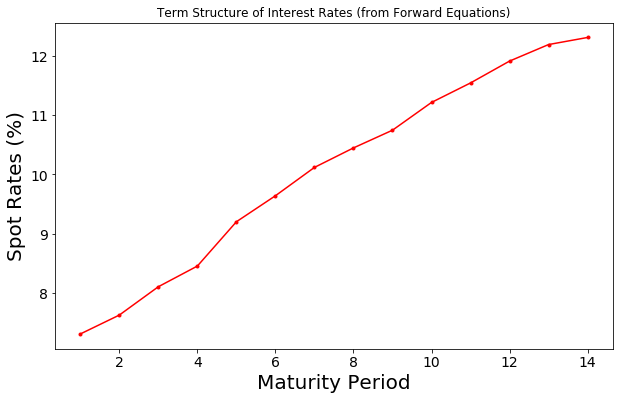

In [26]:
maturity = np.arange(1,n_periods+1)
    
plt.figure(figsize=(10,6))

plt.plot(maturity, spot_fitted, 'r.-', label = 'BDT model')

plt.ylabel('Spot Rates (%)', size = 20)
plt.xlabel('Maturity Period', size = 20)
    
plt.tick_params(labelsize = 14)
    
plt.title('Term Structure of Interest Rates (from Market Data)')

In [3]:
n_periods = 14
b = 0.005
a = 5.0*np.ones(n_periods)

In [15]:
res = sciop.minimize(objective_function, a, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 77
         Function evaluations: 1264
         Gradient evaluations: 79


In [28]:
a_fitted = res.x

spot_fitted = term_structure(a_fitted,b)

print("The fitted model spot rates:")
print(spot_fitted)

print("The model drift parameters:")
print(a_fitted)

The fitted model spot rates:
[ 7.29999996  7.61999997  8.09999795  8.45000475  9.19998456  9.64003465
 10.11994717 10.45004693 10.74998526 11.21998876 11.55002044 11.91997537
 12.20001103 12.32000243]
The model drift parameters:
[ 7.29999996  7.92110561  9.02116417  9.43574582 12.13013684 11.71953764
 12.84959407 12.56672166 12.91802994 15.19509413 14.53681129 15.63565576
 15.1544208  13.44778672]


In [6]:
def objective_function(a_in):
    
    spot_model = term_structure(a_in, b)
    
    diff = spot_model - spot_market
    
    sum_sq = np.sum(diff**2.0)
    
    return sum_sq    

In [7]:
def bdt_short_rate(a_in,b_in):
    
    n = len(a)
    
    rate = np.zeros((n,n))
    
    rate[0,0] = a_in[0] + b_in*0
    
    for i in range(1,n):
        for j in range (0,i+1):
            rate[i,j] = a_in[i]*np.exp(b_in*j)
        
        
    return rate    

In [8]:
def elementary_prices(a_in,b_in):
    
    s = bdt_short_rate(a_in,b_in)/100.0
    
    n_periods = len(a_in)
    
    e_prices = np.zeros((n_periods+1,n_periods+1))
    
    e_prices[0,0] = 1.0
    
    for i in range(1,n_periods+1):            #the 0-th row
        e_prices[i,0] = e_prices[i-1,0]/(2*(1.0 + s[i-1,0]))
        
    for i in range(1,n_periods+1):
        e_prices[i,0] = e_prices[i-1,0]/(2*(1.0 + s[i-1,0]))
        for j in range(1,i+1):
            if i > j:
                e_prices[i,j] = e_prices[i-1,j-1]/(2*(1.0 + s[i-1,j-1])) + e_prices[i-1,j]/(2*(1.0 + s[i-1,j]))
            else:
                e_prices[i,j] = e_prices[i-1,j-1]/(2*(1.0 + s[i-1,j-1]))
                   
    return e_prices   

In [9]:
def zcb_price_forward(a_in,b_in,fv=100.0):
    
    e_prices = elementary_prices(a_in,b_in)
    
    zcb_price_arr = fv*np.sum(e_prices,axis=1)
    
    return zcb_price_arr

In [10]:
def term_structure(a_in,b_in,fv=100.0):
        
    n = len(a_in) + 1
    
    zcb_price_arr = zcb_price_forward(a_in,b_in,fv)
        
    spot_rates = np.zeros(n)
    
    for i in range(1,n):
        spot_rates[i] = (fv/zcb_price_arr[i])**(1/i) - 1.0
           
    return spot_rates[1:]*100.0    